## Analyse specific words in sentiment

### Imports

In [38]:
import turicreate as tc

import matplotlib.pyplot as plt
%matplotlib inline

### Choose important words

In [39]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

### Read product and review data

In [40]:
products = tc.SFrame('https://static.turi.com/datasets/amazon_baby_products/amazon_baby.gl')

In [41]:
products['word_count'] = tc.text_analytics.count_words(products['review'])

### Perform analysis on word counts

In [42]:
def selected_words_count(words, selected_word):
    if (selected_word in [*words.keys()]):
        return words.get(selected_word)
    else:
        return 0

In [43]:
for selected_word in selected_words:
    products[selected_word] = products['word_count'].apply(lambda x: selected_words_count(x, selected_word))

In [44]:
print (products.head)

<bound method SFrame.head of Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int

Rows: 183531

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|    Planetwise Flannel Wipes   | These flannel wipes are OK... |  3.0   |
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
| Stop Pacifier Sucking with... | When the Binky Fairy came ... |  5.0   |
| A Tale of Baby's Days with... | Lovely book, it's bound ti... |  4.0  

In [45]:
most = 0
least = 0
for selected_word in selected_words:
    tmp = products.groupby(selected_word, operations={'count':tc.aggregate.COUNT()}).sort('count',ascending=False)
    print (tmp)
    atleast_one_review = tmp[tmp[selected_word] != 0.0]
    print (f"{selected_word + '->' + str(atleast_one_review['count'].sum())}")

+---------+--------+
| awesome | count  |
+---------+--------+
|   0.0   | 179695 |
|   1.0   |  3634  |
|   2.0   |  173   |
|   3.0   |   21   |
|   4.0   |   8    |
+---------+--------+
[5 rows x 2 columns]

awesome->3836
+-------+--------+
| great | count  |
+-------+--------+
|  0.0  | 135315 |
|  1.0  | 39084  |
|  2.0  |  7441  |
|  3.0  |  1327  |
|  4.0  |  271   |
|  5.0  |   66   |
|  6.0  |   20   |
|  7.0  |   3    |
|  8.0  |   3    |
|  10.0 |   1    |
+-------+--------+
[10 rows x 2 columns]

great->48216
+-----------+--------+
| fantastic | count  |
+-----------+--------+
|    0.0    | 181837 |
|    1.0    |  1627  |
|    2.0    |   63   |
|    3.0    |   4    |
+-----------+--------+
[4 rows x 2 columns]

fantastic->1694
+---------+--------+
| amazing | count  |
+---------+--------+
|   0.0   | 180983 |
|   1.0   |  2393  |
|   2.0   |  140   |
|   3.0   |   9    |
|   4.0   |   4    |
|   5.0   |   2    |
+---------+--------+
[6 rows x 2 columns]

amazing->2548
+----

In [46]:
products = products[products['rating'] != 3]
products['sentiment'] = products['rating'] >= 4

In [47]:
print (products.head)

<bound method SFrame.head of Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int

Rows: 166752

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
| Stop Pacifier Sucking with... | When the Binky Fairy came ... |  5.0   |
| A Tale of Baby's Days with... | Lovely book, it's bound ti... |  4.0   |
| Baby Tracker&reg; - Daily ... | Perfect for new parents

### Train the model

#### Split data into test and train data sets

In [48]:
train_data, test_data = products.random_split(.8, seed = 0)

#### Build the model

In [49]:
sentiment_model = tc.logistic_classifier.create(train_data, target='sentiment', features=selected_words, validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133448

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

Number of coefficients      : 12

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.050468     | 0.847401          | 0.845874            |

| 2         | 3        | 0.087030     | 0.847514          | 0.846085            |

| 3         | 4        | 0.121467     | 0.847626          | 0.846115            |

| 4         | 5        | 0.158027     | 0.847708          | 0.846385            |

| 5         | 6        | 0.194311     | 0.847708          | 0.846385            |

| 6         | 7        | 0.228635     | 0.847708          | 0.846385            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

### Analyse the model

In [50]:
sentiment_model.coefficients.sort('value').print_rows(12)

+-------------+-------+-------+-----------------------+----------------------+
|     name    | index | class |         value         |        stderr        |
+-------------+-------+-------+-----------------------+----------------------+
|   horrible  |  None |   1   |  -2.2513352367590955  | 0.08020249388788439  |
|   terrible  |  None |   1   |  -2.2236614360851292  | 0.07731736203785751  |
|    awful    |  None |   1   |  -2.0529082040313544  | 0.10099735435259255  |
|     hate    |  None |   1   |  -1.3484407222463144  | 0.07715698604297334  |
|     bad     |  None |   1   |   -0.991477880065059  | 0.038484286646990606 |
|     wow     |  None |   1   | -0.009538236067681735 |  0.1604641122471166  |
|    great    |  None |   1   |   0.8630655001196592  | 0.01895505244437695  |
|  fantastic  |  None |   1   |   0.885804756881427   | 0.11167591293399677  |
|   amazing   |  None |   1   |   1.1000933113660258  | 0.09954776260465989  |
|   awesome   |  None |   1   |   1.1335346660341417

### Evalute the model

In [51]:
evaluation = sentiment_model.evaluate(test_data)

In [52]:
evaluation

{'accuracy': 0.8463848186404036,
 'auc': 0.6936022046674926,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  159  |
 |      0       |        0        |  371  |
 |      0       |        1        |  4957 |
 |      1       |        1        | 27817 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9157860082304526,
 'log_loss': 0.3962265467087378,
 'precision': 0.8487520595594068,
 'recall': 0.9943165570488991,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+-----+-------+------+
 | threshold |        fpr         | tpr |   p   |  n   |
 +-----------+--------------------+-----+-------+------+
 |    0.0    |        1.0         | 1.0 | 27976 | 532

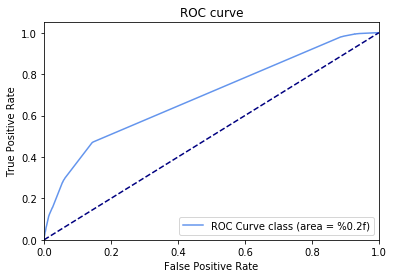

In [53]:
plt.plot(evaluation['roc_curve']['fpr'],
         evaluation['roc_curve']['tpr'],
         color ='cornflowerblue',
         label='ROC Curve class (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

### Predict

In [54]:
print (diaper_champ_reviews.head)

<bound method SFrame.head of Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: 298

Data:
+-------------------------+-------------------------------+--------+
|           name          |             review            | rating |
+-------------------------+-------------------------------+--------+
| Baby Trend Diaper Champ | I LOVE LOVE LOVE this prod... |  4.0   |
| Baby Trend Diaper Champ | I received my Diaper Champ... |  5.0   |
| Baby Trend Diaper Champ | Love it, love it, love it!... |  5.0   |
| Baby Trend Diaper Champ | Let me just say, I LOVE TH... |  5.0   |
| Baby Trend Diaper Champ | I have been using this dia... |  5.0   |
| Baby Trend Diaper Champ | Works great - no smells.  ... |  5.0   |
| Baby Trend Diaper Champ | I love this diaper pale an... |  5.0   |
| Baby Trend Diape

In [55]:
products['predicted_sentiment'] = sentiment_model.predict(products, output_type='probability')

In [56]:
products

Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: 166752

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
| Stop Pacifier Sucking with... | When the Binky Fairy came ... |  5.0   |
| A Tale of Baby's Days with... | Lovely book, it's bound ti... |  4.0   |
| Baby Tracker&reg; - Daily ... | Perfect for new parents. W... |  5.0   |
| Baby Tracker&reg; - Daily ... | A friend of mine pinned th... |  5.0   |
| Baby Tracker&reg; - Daily ... | This has been an easy way ... |  4.0   |
| Baby Tracker&reg; - Daily ... | I love this journal and ou... |  4.0   |
+-------------------------------+-------------------------------+--------+
+-------------------------------+---------+-------+-----------+---------+------+
|           word_count          | awesome | great | fantastic | amazing | love |
+-------------------------------+---------+-------+-----------+---------+------+
| {'recommend': 1.0, 'disapp... |   0.0   |  0.0  |    0.0    |   0.0   | 1.0  |
| {'quilt': 1.0, 'the': 1.0,... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'tool': 1.0, 'clever': 1.... |   0.0   |  0.0  |    0.0    |   0.0   | 2.0  |
| {'rock': 1.0, 'many': 1.0,... |   0.0   |  1.0  |    0.0    |   0.0   | 1.0  |
| {'thumb': 1.0, 'or': 1.0, ... |   0.0   |  1.0  |    0.0    |   0.0   | 0.0  |
| {'for': 1.0, 'barnes': 1.0... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'right': 1.0, 'because': ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'like': 1.0, 'and': 1.0, ... |   0.0   |  0.0  |    1.0    |   0.0   | 0.0  |
| {'in': 1.0, 'pages': 1.0, ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'tracker': 1.0, 'now': 1.... |   0.0   |  0.0  |    0.0    |   0.0   | 2.0  |
+-------------------------------+---------+-------+-----------+---------+------+
+----------+-----+----------+-------+-----+------+-----------+
| horrible | bad | terrible | awful | wow | hate | sentiment |
+----------+-----+----------+-------+-----+------+-----------+
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
+----------+-----+----------+-------+-----+------+-----------+
+---------------------+
| predicted_sentiment |
+---------------------+
|  0.936781924479937  |
|  0.7919288370624461 |
|  0.9829620803909053 |
|  0.972318678885589  |
|  0.9002186948093642 |
|  0.7919288370624461 |
|  0.7919288370624461 |
|  0.9022427410616033 |
|  0.7919288370624461 |
|  0.9829620803909053 |
+---------------------+
[166752 rows x 17 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [57]:
diaper_champ_reviews = products[products['name'] == 'Baby Trend Diaper Champ']

In [58]:
diaper_champ_reviews = diaper_champ_reviews.sort('predicted_sentiment', ascending=False)
diaper_champ_reviews[diaper_champ_reviews['review'].contains('exactly')]

Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: Unknown

Data:
+-------------------------+-------------------------------+--------+
|           name          |             review            | rating |
+-------------------------+-------------------------------+--------+
| Baby Trend Diaper Champ | I read a review below that... |  4.0   |
+-------------------------+-------------------------------+--------+
+-------------------------------+---------+-------+-----------+---------+------+
|           word_count          | awesome | great | fantastic | amazing | love |
+-------------------------------+---------+-------+-----------+---------+------+
| {'key': 1.0, 'have': 1.0, ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
+-------------------------------+---------+-------+-----------+---------+------+
+----------+-----+----------+-------+-----+------+-----------+
| horrible | bad | terrible | awful | wow | hate | sentiment |
+----------+-----+----------+-------+-----+------+-----------+
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
+----------+-----+----------+-------+-----+------+-----------+
+---------------------+
| predicted_sentiment |
+---------------------+
|  0.7919288370624461 |
+---------------------+
[? rows x 17 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [59]:
sentiment_model.predict(diaper_champ_reviews[0:1], output_type='probability')

dtype: float
Rows: 1
[0.9981253623335121]

In [60]:
sentiment_model.predict(diaper_champ_reviews[0:1], output_type='probability')

dtype: float
Rows: 1
[0.9981253623335121]

In [61]:
print (products.head)

<bound method SFrame.head of Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: 166752

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
| Stop Pacifier Sucking with... | When the Binky Fairy came ... |  5.0   |
| A Tale of Baby's Days with... | Lovely book, it's bound ti... |  4.0   |
| Baby Tracker&reg; - Daily ..

### Train the model

#### Split data into test and train data sets

In [62]:
train_data, test_data = products.random_split(.8, seed = 0)

#### Build the model

In [63]:
sentiment_model = tc.logistic_classifier.create(train_data, target='sentiment', features=selected_words, validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133448

Number of classes           : 2

Number of feature columns   : 11

Number of unpacked features : 11

Number of coefficients      : 12

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.045113     | 0.847401          | 0.845874            |

| 2         | 3        | 0.080767     | 0.847514          | 0.846085            |

| 3         | 4        | 0.113357     | 0.847626          | 0.846115            |

| 4         | 5        | 0.147196     | 0.847708          | 0.846385            |

| 5         | 6        | 0.181286     | 0.847708          | 0.846385            |

| 6         | 7        | 0.216591     | 0.847708          | 0.846385            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

### Analyse the model

In [64]:
sentiment_model.coefficients.sort('value').print_rows(12)

+-------------+-------+-------+-----------------------+----------------------+
|     name    | index | class |         value         |        stderr        |
+-------------+-------+-------+-----------------------+----------------------+
|   horrible  |  None |   1   |  -2.2513352367590955  | 0.08020249388788439  |
|   terrible  |  None |   1   |  -2.2236614360851292  | 0.07731736203785751  |
|    awful    |  None |   1   |  -2.0529082040313544  | 0.10099735435259255  |
|     hate    |  None |   1   |  -1.3484407222463144  | 0.07715698604297334  |
|     bad     |  None |   1   |   -0.991477880065059  | 0.038484286646990606 |
|     wow     |  None |   1   | -0.009538236067681735 |  0.1604641122471166  |
|    great    |  None |   1   |   0.8630655001196592  | 0.01895505244437695  |
|  fantastic  |  None |   1   |   0.885804756881427   | 0.11167591293399677  |
|   amazing   |  None |   1   |   1.1000933113660258  | 0.09954776260465989  |
|   awesome   |  None |   1   |   1.1335346660341417

### Evalute the model

In [65]:
evaluation = sentiment_model.evaluate(test_data)

In [66]:
evaluation

{'accuracy': 0.8463848186404036,
 'auc': 0.6936022046674926,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        0        |  159  |
 |      0       |        0        |  371  |
 |      0       |        1        |  4957 |
 |      1       |        1        | 27817 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9157860082304526,
 'log_loss': 0.3962265467087378,
 'precision': 0.8487520595594068,
 'recall': 0.9943165570488991,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+--------------------+-----+-------+------+
 | threshold |        fpr         | tpr |   p   |  n   |
 +-----------+--------------------+-----+-------+------+
 |    0.0    |        1.0         | 1.0 | 27976 | 532

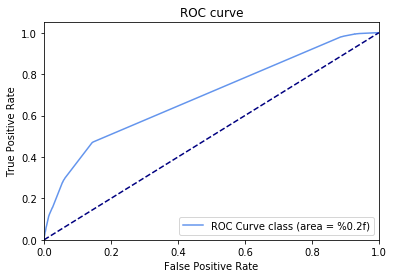

In [67]:
plt.plot(evaluation['roc_curve']['fpr'],
         evaluation['roc_curve']['tpr'],
         color ='cornflowerblue',
         label='ROC Curve class (area = %0.2f)')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

### Predict

In [68]:
print (diaper_champ_reviews.head)

<bound method SFrame.head of Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: 298

Data:
+-------------------------+-------------------------------+--------+
|           name          |             review            | rating |
+-------------------------+-------------------------------+--------+
| Baby Trend Diaper Champ | I LOVE LOVE LOVE this prod... |  4.0   |
| Baby Trend Diaper Champ | I received my Diaper Champ... |  5.0   |
| Baby Trend Diaper Champ | Love it, love it, love it!... |  5.0   |
| Baby Trend Diaper Champ | Let me just say, I LOVE TH... |  5.0   |
| Baby Trend Diaper Champ | I have been using this dia... |  5.0   |
| Baby Trend Diaper Champ | Works great - no smells.  ... |  5.0   |
| Baby Trend Diaper Champ | I love this diaper pale an... |  5.0   |
| Baby Trend Diape

In [69]:
products['predicted_sentiment'] = sentiment_model.predict(products, output_type='probability')

In [70]:
products

Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: 166752

Data:
+-------------------------------+-------------------------------+--------+
|              name             |             review            | rating |
+-------------------------------+-------------------------------+--------+
|     Planetwise Wipe Pouch     | it came early and was not ... |  5.0   |
| Annas Dream Full Quilt wit... | Very soft and comfortable ... |  5.0   |
| Stop Pacifier Sucking with... | This is a product well wor... |  5.0   |
| Stop Pacifier Sucking with... | All of my kids have cried ... |  5.0   |
| Stop Pacifier Sucking with... | When the Binky Fairy came ... |  5.0   |
| A Tale of Baby's Days with... | Lovely book, it's bound ti... |  4.0   |
| Baby Tracker&reg; - Daily ... | Perfect for new parents. W... |  5.0   |
| Baby Tracker&reg; - Daily ... | A friend of mine pinned th... |  5.0   |
| Baby Tracker&reg; - Daily ... | This has been an easy way ... |  4.0   |
| Baby Tracker&reg; - Daily ... | I love this journal and ou... |  4.0   |
+-------------------------------+-------------------------------+--------+
+-------------------------------+---------+-------+-----------+---------+------+
|           word_count          | awesome | great | fantastic | amazing | love |
+-------------------------------+---------+-------+-----------+---------+------+
| {'recommend': 1.0, 'disapp... |   0.0   |  0.0  |    0.0    |   0.0   | 1.0  |
| {'quilt': 1.0, 'the': 1.0,... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'tool': 1.0, 'clever': 1.... |   0.0   |  0.0  |    0.0    |   0.0   | 2.0  |
| {'rock': 1.0, 'many': 1.0,... |   0.0   |  1.0  |    0.0    |   0.0   | 1.0  |
| {'thumb': 1.0, 'or': 1.0, ... |   0.0   |  1.0  |    0.0    |   0.0   | 0.0  |
| {'for': 1.0, 'barnes': 1.0... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'right': 1.0, 'because': ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'like': 1.0, 'and': 1.0, ... |   0.0   |  0.0  |    1.0    |   0.0   | 0.0  |
| {'in': 1.0, 'pages': 1.0, ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
| {'tracker': 1.0, 'now': 1.... |   0.0   |  0.0  |    0.0    |   0.0   | 2.0  |
+-------------------------------+---------+-------+-----------+---------+------+
+----------+-----+----------+-------+-----+------+-----------+
| horrible | bad | terrible | awful | wow | hate | sentiment |
+----------+-----+----------+-------+-----+------+-----------+
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
+----------+-----+----------+-------+-----+------+-----------+
+---------------------+
| predicted_sentiment |
+---------------------+
|  0.936781924479937  |
|  0.7919288370624461 |
|  0.9829620803909053 |
|  0.972318678885589  |
|  0.9002186948093642 |
|  0.7919288370624461 |
|  0.7919288370624461 |
|  0.9022427410616033 |
|  0.7919288370624461 |
|  0.9829620803909053 |
+---------------------+
[166752 rows x 17 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.

In [71]:
diaper_champ_reviews = products[products['name'] == 'Baby Trend Diaper Champ']

In [72]:
diaper_champ_reviews = diaper_champ_reviews.sort('predicted_sentiment', ascending=False)
diaper_champ_reviews[diaper_champ_reviews['review'].contains('exactly')]

Columns:
	name	str
	review	str
	rating	float
	word_count	dict
	awesome	float
	great	float
	fantastic	float
	amazing	float
	love	float
	horrible	int
	bad	float
	terrible	int
	awful	int
	wow	int
	hate	int
	sentiment	int
	predicted_sentiment	float

Rows: Unknown

Data:
+-------------------------+-------------------------------+--------+
|           name          |             review            | rating |
+-------------------------+-------------------------------+--------+
| Baby Trend Diaper Champ | I read a review below that... |  4.0   |
+-------------------------+-------------------------------+--------+
+-------------------------------+---------+-------+-----------+---------+------+
|           word_count          | awesome | great | fantastic | amazing | love |
+-------------------------------+---------+-------+-----------+---------+------+
| {'key': 1.0, 'have': 1.0, ... |   0.0   |  0.0  |    0.0    |   0.0   | 0.0  |
+-------------------------------+---------+-------+-----------+---------+------+
+----------+-----+----------+-------+-----+------+-----------+
| horrible | bad | terrible | awful | wow | hate | sentiment |
+----------+-----+----------+-------+-----+------+-----------+
|    0     | 0.0 |    0     |   0   |  0  |  0   |     1     |
+----------+-----+----------+-------+-----+------+-----------+
+---------------------+
| predicted_sentiment |
+---------------------+
|  0.7919288370624461 |
+---------------------+
[? rows x 17 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.

In [73]:
sentiment_model.predict(diaper_champ_reviews[0:1], output_type='probability')

dtype: float
Rows: 1
[0.9981253623335121]